In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D, LSTM
from keras.layers import Permute, Reshape
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [5]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    print('File Path : ',filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [10]:
# load all train
X_train, Y_train = load_dataset_group('train', '/content/drive/MyDrive/MCA Main Project/UCI HAR/')
# load all test
X_test, Y_test = load_dataset_group('test', '/content/drive/MyDrive/MCA Main Project/UCI HAR/')

# zero-offset class values
Y_train = Y_train - 1
Y_test = Y_test - 1
# one hot encode y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('X_train.shape : ', X_train.shape)
print('Y_train.shape : ', Y_train.shape)
print('X_test.shape : ', X_test.shape)
print('Y_test.shape : ', Y_test.shape)

File Path :  /content/drive/MyDrive/MCA Main Project/UCI HAR/train/Inertial Signals/
File Path :  /content/drive/MyDrive/MCA Main Project/UCI HAR/test/Inertial Signals/
X_train.shape :  (7352, 128, 9)
Y_train.shape :  (7352, 6)
X_test.shape :  (2947, 128, 9)
Y_test.shape :  (2947, 6)


In [11]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))


In [12]:
verbose = 1
epochs = 30
batch_size = 20

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
hist = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test), batch_size=batch_size, verbose=verbose)

# evaluate model
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))


Epoch 1/30
368/368 [==============================] - 28s 67ms/step - loss: 0.3929 - accuracy: 0.8437 - val_loss: 0.4032 - val_accuracy: 0.8789
Epoch 2/30
368/368 [==============================] - 20s 55ms/step - loss: 0.1612 - accuracy: 0.9363 - val_loss: 0.4515 - val_accuracy: 0.8901
Epoch 3/30
368/368 [==============================] - 23s 64ms/step - loss: 0.1237 - accuracy: 0.9478 - val_loss: 0.4723 - val_accuracy: 0.8792
Epoch 4/30
368/368 [==============================] - 20s 56ms/step - loss: 0.1177 - accuracy: 0.9498 - val_loss: 0.5241 - val_accuracy: 0.9046
Epoch 5/30
368/368 [==============================] - 23s 61ms/step - loss: 0.1215 - accuracy: 0.9505 - val_loss: 0.2926 - val_accuracy: 0.9053
Epoch 6/30
368/368 [==============================] - 21s 56ms/step - loss: 0.1025 - accuracy: 0.9558 - val_loss: 0.3241 - val_accuracy: 0.9158
Epoch 7/30
368/368 [==============================] - 20s 56ms/step - loss: 0.1001 - accuracy: 0.9561 - val_loss: 0.3850 - val_accuracy:

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 30, 64)         56320     
                                                                 
 dropout (Dropout)           (None, 1, 30, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 302,982
Trainable params: 302,982
Non-trainable params: 0
_________________________________________________________________


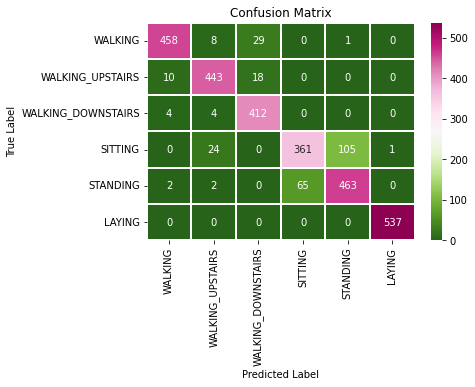

In [13]:
# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = ['WALKING',
          'WALKING_UPSTAIRS',
          'WALKING_DOWNSTAIRS',
          'SITTING',
          'STANDING',
          'LAYING']
y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='PiYG_r',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
